In [ ]:
import numpy as np
import pandas as pd
import sympy
from sympy import *
from operator import mul
from functools import reduce
import mpmath as mp
from mpmath import fac
import functools
from sympy import init_printing
from sympy.core.decorators import _sympifyit, call_highest_priority
from IPython.display import display_latex
init_printing()
import copy
import collections

In [ ]:
class LieOperator(Expr):
    '''
    Defined algebra for the Lie operator:
    Addition: Hamiltonian functions get added into a new Lie operator
    Multiplication: Poisson bracket gets applied
    Exp: Lie Transfer Map gets applied
    BCH: Baker- Campbell - Hausdorff expansion get applied as Lie Tranfer Map concatenation
    CAUTION: NOT ASSOCIATIVE

    INPUT: Hamiltonian, generalized coordinates and momenta
    '''
    
    
    _op_priority = 11.0

    is_commutative = False
    
    
    def __new__(cls, ham, indep_coords, indep_mom):
        if not isinstance(indep_coords, list): #create list of coords
            indep_coords = [indep_coords]
        if not isinstance(indep_mom, list): #create list of momenta
            indep_mom = [indep_mom]
        
        #same number of coordinates and momenta have to be entered
        assert(len(indep_coords)==len(indep_mom)),'The number of coords and momenta is not the same'
            
        obj = Expr.__new__(cls, ham, indep_coords, indep_mom)
        obj._ham = ham
        obj._indep_coords = indep_coords
        obj._indep_mom = indep_mom
        return obj
    
    
    @property
    def ham(self):
        return self._ham
    
    @ham.setter
    def ham(self, other):
        #Input has to be a function
        assert(not(S(ham.is_number))), 'Input has to be a function and not a number'
        self._ham = self._ham.subs(self.ham, other).doit()
        
    @property
    def indep_coords(self):
        return self._indep_coords
    
    @indep_coords.setter
    def indep_coords(self, other):
        self._indep_coords = other
        
    @property
    def indep_mom(self):
        return self._indep_mom
    
    @indep_mom.setter
    def indep_mom(self, other):
        self._indep_mom = other
        
        
        
    
    #Algebraic properties 

    #Define Addition
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__radd__')
    def __add__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__add__')
    def __radd__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)
    
    #Define Substraction
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rsub__')
    def __sub__(self, other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham - other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__sub__')
    def __rsub__(self, other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham - other.ham, self.indep_coords,self.indep_mom)
        
    #Define Multiplication
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rmul__')
    def __mul__(self, other):
        return self.LieOperatorMul(other)
        
        
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__mul__')
    def __rmul__(self,other):
        if S(other).is_number:
            return LieOperator(other*self.ham,self.indep_coords,self.indep_mom)
        elif not isinstance(other, LieOperator):
            other = LieOperator(other,self.indep_coords,self.indep_mom) 
        return other.LieOperatorMul(self)
    
    
    def LieOperatorMul(_ham1, _ham2):
        if not isinstance(_ham2, LieOperator):
            _ham2 = LieOperator(_ham2,_ham1.indep_coords,_ham1.indep_mom) 
        if not collections.Counter(_ham1.indep_coords) == collections.Counter(_ham2.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return _ham1.Poisson(_ham2)
    
    
    #Calcualte Poisson bracket with input function
    def Poisson(self,other):
        _h1 = self.ham
        _h2 = other.ham
        hp = S(0)
        for qi,pi in zip(self.indep_coords, self.indep_mom):
            hp += _h1.diff(qi) * _h2.diff(pi) 
            hp -= _h1.diff(pi) * _h2.diff(qi)
        return LieOperator(hp,self.indep_coords,self.indep_mom)
    
    
    #Exponential Map: Lie Transform Map
    #Calculate the exponential map of the Lie operator to the input cutoff
    def LieMap(self,other,power):
        s = S(0)
        
        for i in range(power+1):
            s += sympy.Rational(1,factorial(i))*(self.ExpPowerLieBracket(other,i)).ham
        
        return LieOperator(s,self.indep_coords,self.indep_mom) 
    
    
    
    #Successively apply Poisson bracket to input function to the input cutoff
    def ExpPowerLieBracket(self, other, power):
        _op1 = self
        _op2 = other
        
        
        if power > 0:
            hp = _op1*_op2
            
            for s in range(1,power):
                hp = _op1*hp
                
        else:
            if not isinstance(_op2, LieOperator):
                _op2 = LieOperator(_op2, self.indep_coords,self.indep_mom)
            
            hp = _op2
        
        return hp
    
    #Up to order 4 done manually to have a working copy, arbitrary ordered needs to be still written
    def BCH(self,other,n):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        elif n < 1:
            raise ValueError(n, ' is not a valid order. Number has to be natural.')
            
        _op1 = LieOperator(self.ham,self.indep_coords, self.indep_mom)
        _op2 = LieOperator(other.ham, other.indep_coords, other.indep_mom)
        
        
        temp = _op1 + _op2
        
        if n > 1:
            temp = temp + sympy.Rational(1,2) * _op1 * _op2
        
        if n > 2:
            temp = temp + sympy.Rational(1,12) * _op1 * (_op1 * _op2) + sympy.Rational(1,12) * _op2 * (_op2 * _op1)
           
        if n > 3:
            temp = temp  + sympy.Rational(1,24) * _op2 * (_op1 * (_op2 * _op1))
        
       
        return temp

# Test Demos

To replace de dummy hamiltonian and evaluate the derivative use:

.subs(Dummy Function,Your Function).doit()

In [ ]:
x, y, px, py = sympy.symbols('x y px py')
H1 = sympy.Function('H1', commutative=True)(x,px)
H2 = sympy.Function('H2', commutative=True)(x,px)
H3 = sympy.Function('H3', commutative=True)(x,px)
H4 = sympy.Function('H4', commutative=True)(x,y,px,py)
H5 = sympy.Function('H5', commutative=True)(x,y,px,py)
la = LieOperator(H1,x,px)
lb = LieOperator(H2,x,px)
lc = LieOperator(H3,x,px)
lz = LieOperator(H4,[x,y],[px,py])
lw = LieOperator(H5,[x,y],[px,py])

In [ ]:
lw.ham

## Addition

In [4]:
la + lb

## Substraction

In [5]:
la - lb

## Multiplication

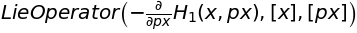

In [6]:
la * x

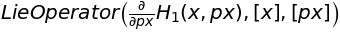

In [7]:
x * la

In [8]:
5 * la

In [9]:
la * 5

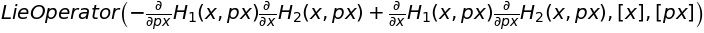

In [10]:
la * lb

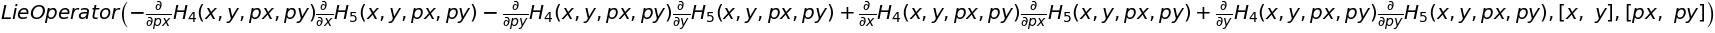

In [11]:
lz * lw

In [12]:
la * lw

TypeError: Lie Operators do not have the same dimension.

## Lie Transform Map

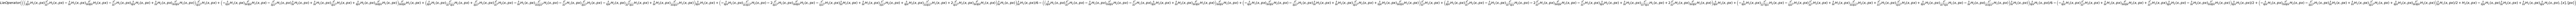

In [13]:
la.LieMap(H2,3)

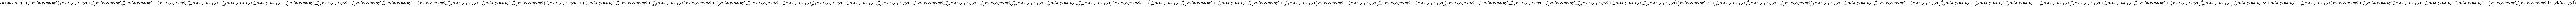

In [15]:
lw.LieMap(H4,2)

# BCH  Concatenation up to 4th order

In [16]:
la.BCH(lb,1)

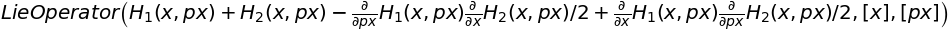

In [17]:
la.BCH(lb,2)

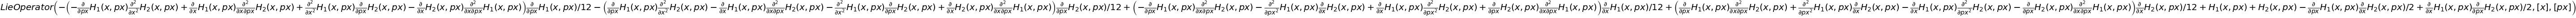

In [18]:
la.BCH(lb,3)

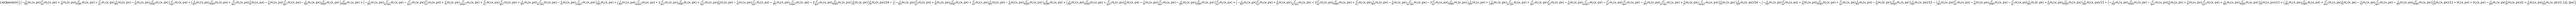

In [19]:
la.BCH(lb,4)

In [20]:
lw.BCH(lz,1)

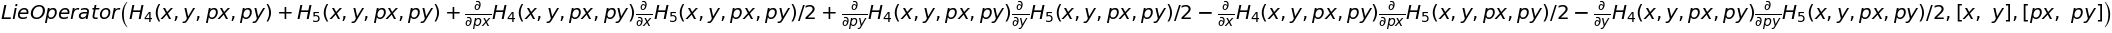

In [21]:
lw.BCH(lz,2)

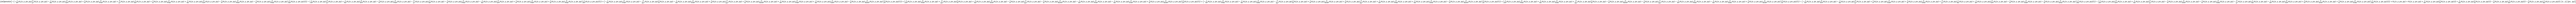

In [22]:
lw.BCH(lz,3)

In [96]:
x, p, k, L, y, py = sympy.symbols('x PX k L y PY')
l = - sympy.Rational(1,2)*(k*(x - L*p)**2 + p**2)
lo = LieOperator(l,x,p)

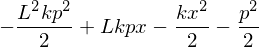

In [56]:
l.expand()

In [57]:
H0 = lo.LieMap(p,0).ham.expand()

In [58]:
H1 = lo.LieMap(p,1).ham.expand() - H0

In [59]:
H2 = lo.LieMap(p,2).ham.expand() - H0 - H1

In [60]:
H3 = lo.LieMap(p,3).ham.expand() - H0 - H1 - H2

In [61]:
H4 = lo.LieMap(p,4).ham.expand() - H0 - H1 - H2 - H3

In [62]:
H5 = lo.LieMap(p,5).ham.expand() - H0 - H1 - H2 - H3 - H4

In [63]:
H6 = lo.LieMap(p,6).ham.expand() - H0 - H1 - H2 - H3 - H4 - H5

In [64]:
H7 = lo.LieMap(p,7).ham.expand() - H0 - H1 - H2 - H3 - H4 - H5 - H6

In [65]:
H8 = lo.LieMap(p,8).ham.expand() - H0 - H1 - H2 - H3 - H4 - H5 - H6 - H7

In [66]:
H9 = lo.LieMap(p,9).ham.expand() - H0 - H1 - H2 - H3 - H4 - H5 - H6 - H7 - H8

In [67]:
H10 = lo.LieMap(p,10).ham.expand() - H0 - H1 - H2 - H3 - H4 - H5 - H6 - H7 - H8 - H9

In [68]:
H0

In [69]:
H1

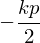

In [70]:
H2

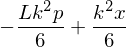

In [71]:
H3

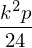

In [72]:
H4

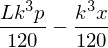

In [73]:
H5

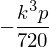

In [74]:
H6

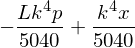

In [75]:
H7

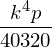

In [76]:
H8

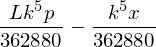

In [77]:
H9

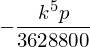

In [78]:
H10

In [81]:
A = Matrix([[1, L,0,0],[0,1,0,0],[0,0,1,L],[0,0,0,1]])

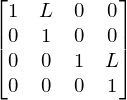

In [82]:
A

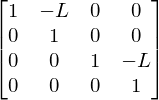

In [83]:
A.inv()

In [97]:
op = LieOperator((k/6)*((x-L*p)**3 - 3*(x - L*p)*(y - L * py)**2),[x,p],[y,py])

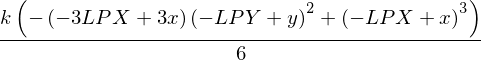

In [99]:
op.ham

In [100]:
op.LieMap(x,5)